In [147]:
%matplotlib inline

import sys
import os

# Add parent directory (where pygestalt lives) to sys.path
sys.path.append(os.path.abspath(".."))

from pathlib import Path
import numpy as np
from skimage.filters import gabor
from matplotlib import pyplot as plt
from matplotlib.pyplot import *

import pygestalt as gs
from pygestalt import sampler

import torch
import torch.nn as nn
import torchvision

In [148]:
def make_gabor_kernels(ksize, sigma, lam, gamma=0.5, K=20, device='cpu'):
    """
    Generate K Gabor kernels with different orientations.
    Returns: tensor of shape (K, 1, ksize, ksize)
    """
    kernels = []
    for theta in np.linspace(0, np.pi, K, endpoint=False):  # 0 to 180 degrees
        x, y = np.meshgrid(np.arange(ksize)-ksize//2, np.arange(ksize)-ksize//2)
        x_theta = x * np.cos(theta) + y * np.sin(theta)
        y_theta = -x * np.sin(theta) + y * np.cos(theta)
        gb = np.exp(-0.5 * (x_theta**2 + (gamma*y_theta)**2)/sigma**2) * np.cos(2*np.pi*x_theta/lam)
        gb = gb - gb.mean()  # zero mean
        kernels.append(gb)
    kernels = np.stack(kernels)[:, None, :, :]  # (K,1,ksize,ksize)
    return torch.tensor(kernels, dtype=torch.float32, device=device)

In [149]:
kernel_tensor_1 = make_gabor_kernels(ksize=7, sigma=2, lam=4)
kernel_tensor_2 = make_gabor_kernels(ksize=31, sigma=5, lam=15)

In [150]:
outdir = Path(os.getcwd()) / 'outputs'
os.makedirs(outdir, exist_ok=True)

#Ps = np.random.uniform(size=(4,2))
#Ps = np.vstack([[0.2,0], Ps, [0.8,1]])
Ps = np.array([[0.,0.], [0.1,0.9], [0.9,0.1], [1.,1.]])
#Ps = np.array([[0.,0.], [1.,1.]])

radius = 0.02
thresh = 1e-3

%time C, H = sampler.draw_positions(radius, sampler.bezier_curve(Ps), thresh=thresh)
%time D, _ = sampler.draw_positions(radius, sampler.box(), exclusions=C, thresh=thresh)

CPU times: user 3.45 s, sys: 39.3 ms, total: 3.49 s
Wall time: 3.54 s
CPU times: user 17.9 s, sys: 157 ms, total: 18 s
Wall time: 18.1 s


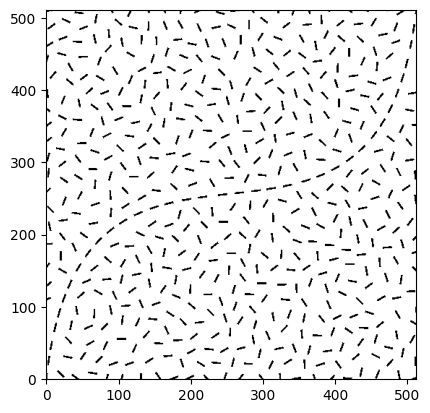

In [151]:
# Define the patch function

l=0.025
w=0.005
pfunc = lambda z,h: gs.patch.segment(z, h, l, w)

N = 512
If, Tf = gs.patch.generate_image(C, H, N=N, pfunc=pfunc)
Ig, Tg = gs.patch.generate_image(D, N=N, pfunc=pfunc)

I = If + Ig

image = torch.tensor(Ig)
image_tensor = image.unsqueeze(0).unsqueeze(0)

image_tensor = image_tensor.to(torch.float32)
kernel_tensor_1 = kernel_tensor_1.to(torch.float32)
kernel_tensor_2 = kernel_tensor_2.to(torch.float32)

plt.imshow(I, aspect='equal', origin='lower', cmap='binary')

In [152]:
conv1 = nn.functional.conv2d(image_tensor, kernel_tensor_1, stride=1, padding=3)
output = nn.functional.conv2d(conv1, kernel_tensor_2, stride=1, padding=15, groups= 20)

print(conv1.shape)
print(output.shape)

torch.Size([1, 20, 512, 512])
torch.Size([1, 20, 512, 512])


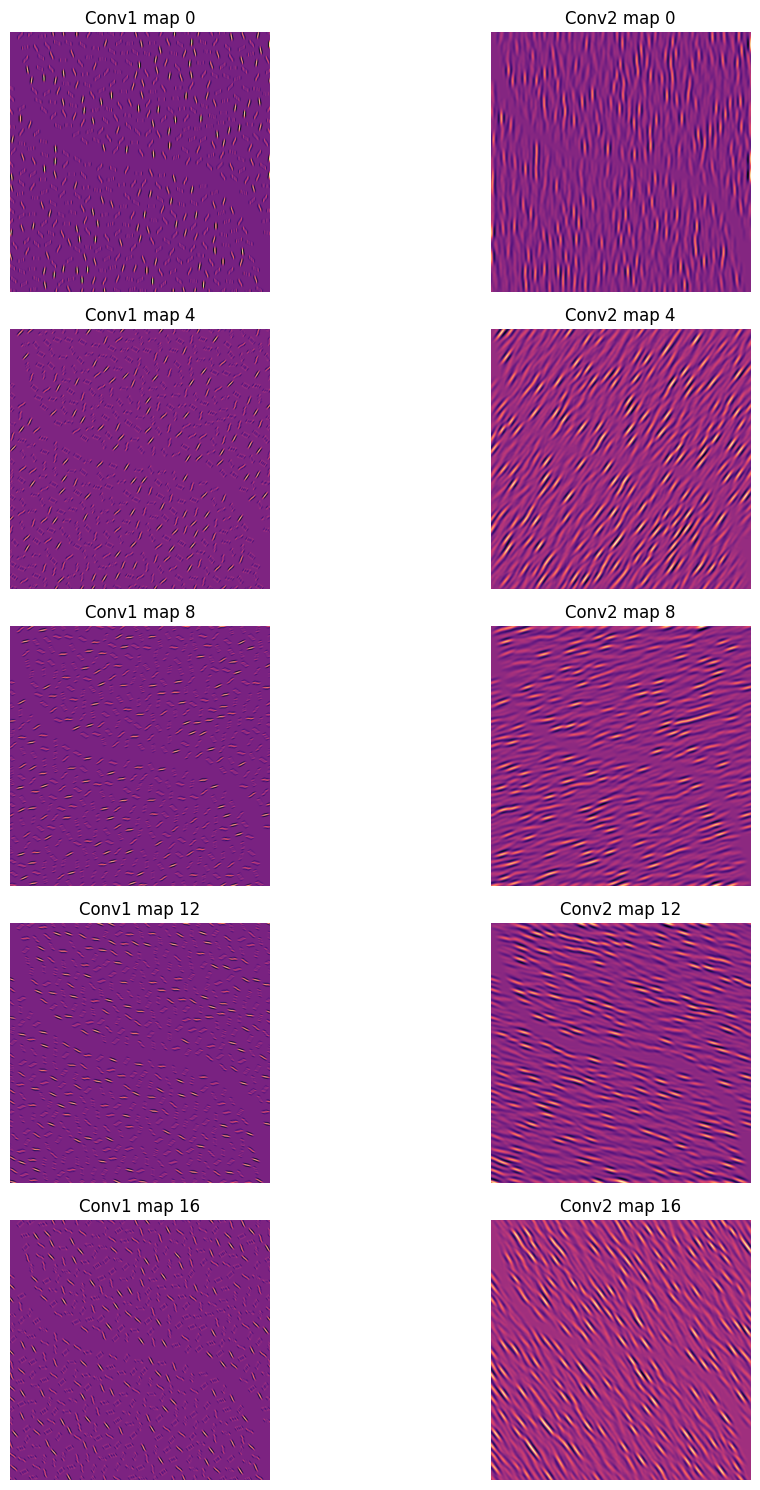

In [153]:
# Remove batch dimension: (20, H, W)
feature_maps1 = conv1.squeeze(0)
feature_maps2 = output.squeeze(0)

# Pick every 4th map
indices_to_show = list(range(0, feature_maps1.shape[0], 4))
num = len(indices_to_show)

plt.figure(figsize=(12, 3 * num))

for i, idx in enumerate(indices_to_show):
    # First convolution on the left
    plt.subplot(num, 2, 2*i + 1)
    plt.imshow(feature_maps1[idx].detach().cpu().numpy(), cmap='magma')
    plt.title(f"Conv1 map {idx}")
    plt.axis('off')
    
    # Second convolution on the right
    plt.subplot(num, 2, 2*i + 2)
    plt.imshow(feature_maps2[idx].detach().cpu().numpy(), cmap='magma')
    plt.title(f"Conv2 map {idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()